# Jupiter Notebook to build a quick and imperfect prediction solution

This notebook is an attempt to train a model to predict the salary in Data Science based on the kaggle dataset from https://www.kaggle.com/datasets/lainguyn123/data-science-salary-landscape.

In [60]:
# Package for linear regressions


import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn import svm 

#from xgboost import XGBRegressor
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, LassoCV, RidgeCV, ElasticNet
from sklearn.linear_model import LinearRegression,BayesianRidge 
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score,root_mean_squared_log_error
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import PowerTransformer,StandardScaler
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import plotly.express as px
sns.set_theme()
import warnings
warnings.filterwarnings('ignore')

## Loading and Cleaning datasets

In this section, we will load the dataset and extract the features and performs the cleaning.

In [61]:
pd.options.display.float_format = '{:.2f}'.format

salaries_dataset_url = './ds_salaries.csv'
full_dataset = pd.read_csv(salaries_dataset_url)
full_dataset.describe(include='all').T



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,607.00,NaN,NaN,NaN,303.00,175.37,0.00,151.50,303.00,454.50,606.00
work_year,607.00,NaN,NaN,NaN,2021.41,0.69,2020.00,2021.00,2022.00,2022.00,2022.00
experience_level,607,4,SE,280,NaN,NaN,NaN,NaN,NaN,NaN,NaN
employment_type,607,4,FT,588,NaN,NaN,NaN,NaN,NaN,NaN,NaN
job_title,607,50,Data Scientist,143,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salary,607.00,NaN,NaN,NaN,324000.06,1544357.49,4000.00,70000.00,115000.00,165000.00,30400000.00
salary_currency,607,17,USD,398,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salary_in_usd,607.00,NaN,NaN,NaN,112297.87,70957.26,2859.00,62726.00,101570.00,150000.00,600000.00
employee_residence,607,57,US,332,NaN,NaN,NaN,NaN,NaN,NaN,NaN
remote_ratio,607.00,NaN,NaN,NaN,70.92,40.71,0.00,50.00,100.00,100.00,100.00


In [62]:

#def my_preparation(X, Y):
# Reorder the salary column and remove the salary and currency columns and ID
ignored_cols =  ['Unnamed: 0', 'salary', 'salary_currency', 'salary_in_usd']
X = full_dataset.drop(ignored_cols, axis=1)
# We convert the work year as a categorical feature
X['work_year'] = X['work_year'].map(str)
X['remote_ratio_str'] = X['remote_ratio'].map(str)

data_with_dummies = pd.get_dummies(X, drop_first=False)
data_preprocessed = data_with_dummies.replace({True:1, False:0})
X = data_preprocessed

# We apply log on the salary feature
Y =  np.log(full_dataset["salary_in_usd"])
X.info()
Y.info()
inputs = X
targets = Y
feature_cols = X.columns

print("Features num=", len(feature_cols), feature_cols)
X.to_csv('train.csv', index=False)  

def old_prep():
    cols = ['Unnamed: 0', 'salary', 'salary_currency', 'employee_residence']
    data_cleaned = full_dataset.drop(cols, axis=1)
    data_cleaned['work_year'] = data_cleaned['work_year'].map(str)

    data_with_dummies = pd.get_dummies(data_cleaned, drop_first=True)
    data_preprocessed = data_with_dummies.replace({True:1, False:0})

    targets = np.log(data_preprocessed['salary_in_usd'])
    inputs = data_preprocessed.drop('salary_in_usd', axis=1)

X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.1, random_state=42)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Columns: 175 entries, remote_ratio to remote_ratio_str_50
dtypes: int64(175)
memory usage: 830.0 KB
<class 'pandas.core.series.Series'>
RangeIndex: 607 entries, 0 to 606
Series name: salary_in_usd
Non-Null Count  Dtype  
--------------  -----  
607 non-null    float64
dtypes: float64(1)
memory usage: 4.9 KB
Features num= 175 Index(['remote_ratio', 'work_year_2020', 'work_year_2021', 'work_year_2022',
       'experience_level_EN', 'experience_level_EX', 'experience_level_MI',
       'experience_level_SE', 'employment_type_CT', 'employment_type_FL',
       ...
       'company_location_TR', 'company_location_UA', 'company_location_US',
       'company_location_VN', 'company_size_L', 'company_size_M',
       'company_size_S', 'remote_ratio_str_0', 'remote_ratio_str_100',
       'remote_ratio_str_50'],
      dtype='object', length=175)


### Split the dataset in train and test



In [63]:
print("X_train", X_train.shape)
print("X_test", X_test.shape)
print("Y_train", y_train.shape)
print("Y_test", y_test.shape)

X_train (546, 175)
X_test (61, 175)
Y_train (546,)
Y_test (61,)


In [64]:
# List empty columns (normally none)
print("Empty columns in training set", X_train.columns[X_train.isnull().any()])

Empty columns in training set Index([], dtype='object')


## Model training

We will use a hierarchical model to train.

In [147]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import QuantileTransformer
from xgboost import XGBRegressor
def fit_model(inputs, targets):
  
    params_lr = {'alpha': 2.1596631438375864, 'l1_ratio': 0.7621516892127179}
    params_dt = {'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 8}
    params_rf = {'n_estimators': 472, 'max_samples': 0.09686470240301956, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_leaf_nodes': 46}
    params_gb = {'n_estimators': 220, 'learning_rate': 0.02139326388712453, 'subsample': 0.4151420539955953, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_leaf_nodes': 13}
    
    rg_net = ElasticNet(**params_lr) 
    rg_dt = DecisionTreeRegressor(**params_dt)
    rg_rf = RandomForestRegressor(**params_rf)
    rg_gb = GradientBoostingRegressor(**params_gb)
    rg_knn = KNeighborsRegressor(n_neighbors=2)
    rg_lasso =  LassoCV(cv=5, random_state=0)
    rg_lr = LinearRegression();
    
    estimators = [
        ("Random Forest", rg_rf),
        ('ElasticNet', rg_net),
        ('DecisionTree', rg_dt), 
        ('gb', rg_gb),
        #("LassoCV", lasso_pipeline),
        #("Gradient Boosting", gbdt_pipeline),
        ("KNN", rg_knn),
        #("LR", LinearRegression()),   
        #("XGB", make_pipeline(linear_preprocessor, XGBRegressor())),   
        #("LGBM", make_pipeline(linear_preprocessor, LGBMRegressor())),   
        #("SVR_linear", make_pipeline(linear_preprocessor, SVR(cache_size=800))),   
        #("SVR_rbf", make_pipeline(linear_preprocessor, SVR(cache_size=800, kernel="rbf"))),   
        #('Ridge', make_pipeline(linear_preprocessor, Ridge(alpha=10)))
    ]
    #estimators = [('lr', rg_lr),('dt', rg_dt), ('rf', rg_rf), ('gb', rg_gb)]
    #stacking_regressor = StackingRegressor(estimators=estimators, cv=5, final_estimator=LinearRegression())
    stacking_regressor = rg_lr;
    stacking_regressor.fit(inputs, targets)
    return stacking_regressor


regr = fit_model( X_train, y_train )

## Predict the value for the test dataset
y_pred = regr.predict(X_test)
print(y_pred[0:5])
print(y_test[0:5])

## Compute Accuracy
    

# The coefficients
#print("Coefficients: \n", regr.coef_)
# The mean squared error
print("root_mean_squared_log_error: %.2f" % root_mean_squared_log_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination, R2: %.2f" % r2_score(y_test, y_pred))


[11.90189319 11.90189319 11.80973027 12.12877016 10.61818435]
563   11.85
289   11.81
76    11.51
78    12.51
182   10.17
Name: salary_in_usd, dtype: float64
root_mean_squared_log_error: 0.05
Coefficient of determination, R2: 0.67


### Graph and precision evaluation

### Compute accuracy

root_mean_squared_log_error: 0.05
Coefficient of determination, R2: 0.67


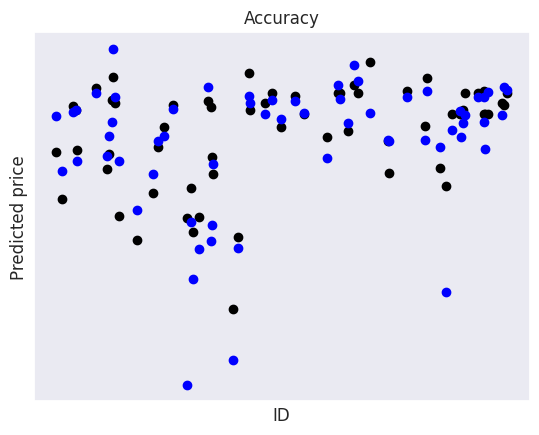

<class 'pandas.core.frame.DataFrame'>
Index: 61 entries, 563 to 420
Columns: 178 entries, remote_ratio to id
dtypes: float64(2), int64(176)
memory usage: 85.3 KB
None


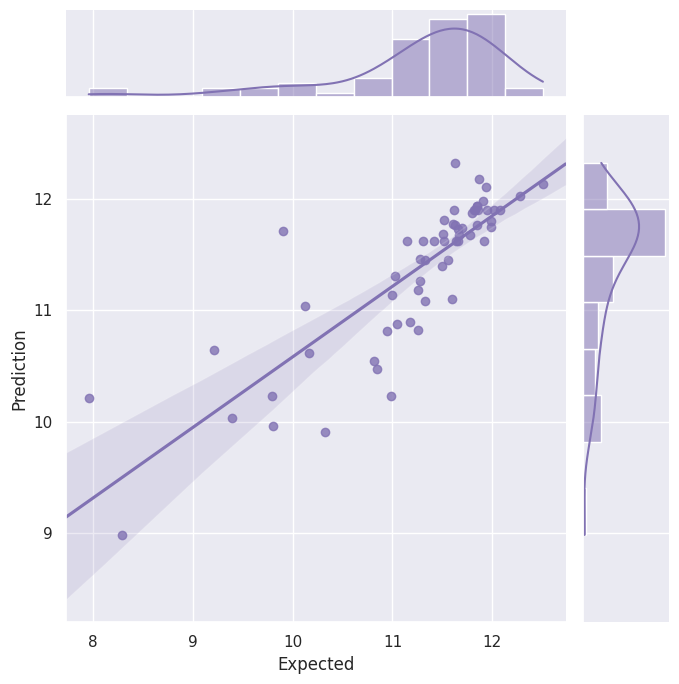

In [144]:

# Plot outputs
plt.scatter(X_test.index, y_pred, color="black")
plt.scatter(X_test.index, y_test, color="blue")
#plt.scatter(train["Id"], y_test, color="blue")
#plt.plot(test_features_X_df,  test_predicted_Y_df, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())
plt.tick_params(axis='both', labelsize=12, width=2, length=5)  # Style

plt.xlabel('ID')
plt.ylabel('Predicted price')
plt.title('Accuracy')
plt.show()


sns.set_theme(style="darkgrid")

data = X_test.copy()
data["Prediction" ] = y_pred
data["Expected" ] = y_test
data["id"] = data.index
print(data.info())
g = sns.jointplot(x="Expected", y="Prediction", data=data,
                  kind="reg", truncate=False,
                  color="m", height=7)


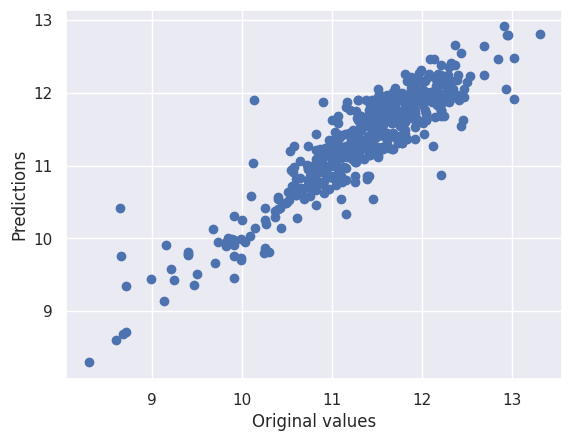

In [145]:
reg=LinearRegression()
reg.fit(X_train, y_train)
yhat = reg.predict(X_train)
plt.scatter(y_train, yhat)
plt.xlabel('Original values')
plt.ylabel('Predictions')
plt.show()


In [146]:
predictions = reg.predict(X_test)
predictions2 = regr.predict(X_test)


print("root_mean_squared_log_error: %.2f" % root_mean_squared_log_error(y_test, predictions))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination, R2: %.2f" % r2_score(y_test, predictions))



results = pd.DataFrame({'Prediction': np.exp(predictions), 'Actual': np.exp(y_test)})
results["Prediction my model"] = np.exp(predictions2)
results['Difference'] = np.exp(y_test) - np.exp(predictions)
results['Difference %'] = abs(results['Difference'])/results['Actual']
results['Difference2'] = np.exp(y_test) - np.exp(predictions2)
results['Difference2 %'] = abs(results['Difference2'])/results['Actual']

results.sort_values(by='Difference %')

root_mean_squared_log_error: 0.05
Coefficient of determination, R2: 0.67


,Prediction,Actual,Prediction my model,Difference,Difference %,Difference2,Difference2 %
29,117107.52,117104.00,117107.52,-3.52,0.00,-3.52,0.00
443,77788.28,78526.00,77788.28,737.72,0.01,737.72,0.01
332,111734.43,112900.00,111734.43,1165.57,0.01,1165.57,0.01
540,111734.43,115934.00,111734.43,4199.57,0.04,4199.57,0.04
602,147545.69,154000.00,147545.69,6454.31,0.04,6454.31,0.04
...,...,...,...,...,...,...,...
238,7985.10,4000.00,7985.10,-3985.10,1.00,-3985.10,1.00
210,62035.27,24823.00,62035.27,-37212.27,1.50,-37212.27,1.50
521,41856.50,10000.00,41856.50,-31856.50,3.19,-31856.50,3.19
208,121799.85,20000.00,121799.85,-101799.85,5.09,-101799.85,5.09
